In [35]:
import xarray as xr
from fsspec.implementations.http import HTTPFileSystem

In [36]:
# We can access our API using fsspec's HTTPFileSystem
fs = HTTPFileSystem()

# The http mapper gives us a dict-like interface to the API
http_map = fs.get_mapper("http://0.0.0.0:8090/datasets/dbofs")

ds = xr.open_zarr(http_map, consolidated=True)
ds

<xarray.Dataset>
Dimensions:        (ocean_time: 516, tracer: 2, s_rho: 10, s_w: 11,
                    boundary: 4, eta_rho: 732, xi_rho: 119, eta_psi: 731,
                    xi_psi: 118, eta_u: 732, xi_u: 118, eta_v: 731, xi_v: 119)
Coordinates:
  * ocean_time     (ocean_time) datetime64[ns] 2023-03-15T01:00:00 ... 2023-0...
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/86)
    Akk_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r           (ocean_time, s_rho) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    Cs_w           (ocean_time, s_w) float64 dask.array<chunksize=(1, 11), meta=np.ndarray>
    ...             ...
    theta_s        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u              (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 732, 118), meta=np.ndarray>
    v              (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 731, 119), meta=np.ndarray>
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 6, 732, 119), meta=np.ndarray>
    xl             (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20230315.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

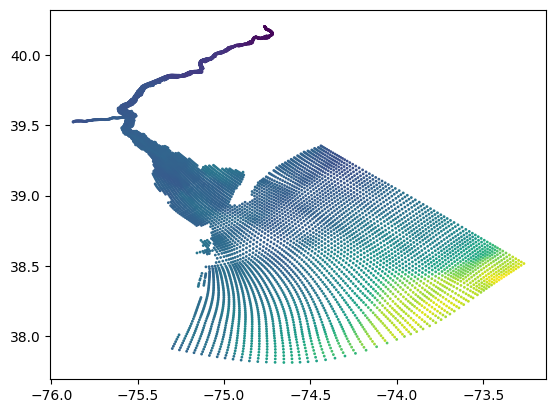

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

temp = ds.temp.isel(ocean_time=0, s_rho=0)

plt.scatter(ds.lon_rho, ds.lat_rho, c=temp, s=1)